In [1]:
# quantum imports
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, Session
from timeit import default_timer as timer
from qiskit_aer import AerSimulator
# from pylatexenc import *
from qiskit.visualization import plot_circuit_layout
import warnings
warnings.filterwarnings('ignore')

QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True)

ImportError: cannot import name 'SamplerPubResult' from 'qiskit.primitives.containers' (C:\Users\subra\Videos\GitHub Repos\cog-mod-proj24\venv\Lib\site-packages\qiskit\primitives\containers\__init__.py)

In [2]:
# classical imports
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import combinations

In [6]:
# classical approach
def held_karp(distance_matrix):
    n = len(distance_matrix)
    dp = {}
    
    # Initialize base cases
    for k in range(1, n):
        dp[(1 << k, k)] = (distance_matrix[0][k], [0, k])
    
    # Fill DP table
    for subset_size in range(2, n):
        for subset in combinations(range(1, n), subset_size):
            subset_mask = sum(1 << i for i in subset)
            for j in subset:
                prev_mask = subset_mask & ~(1 << j)
                min_dist = float('inf')
                min_path = None
                for k in subset:
                    if k == j:
                        continue
                    if (prev_mask, k) in dp:
                        dist = dp[(prev_mask, k)][0] + distance_matrix[k][j]
                        if dist < min_dist:
                            min_dist = dist
                            min_path = dp[(prev_mask, k)][1] + [j]
                dp[(subset_mask, j)] = (min_dist, min_path)
    
    final_mask = (1 << n) - 1
    min_dist = float('inf')
    min_path = None
    for j in range(1, n):
        if (final_mask, j) in dp:
            dist = dp[(final_mask, j)][0] + distance_matrix[j][0]
            if dist < min_dist:
                min_dist = dist
                min_path = dp[(final_mask, j)][1] + [0]
    
    return min_dist, min_path

def generate_random_distance_matrix(n):
    matrix = np.random.rand(n, n)
    matrix = (matrix + matrix.T) / 2
    np.fill_diagonal(matrix, 0)
    return matrix

def run_tsp_on_graph_sizes(sizes):
    runtimes = []
    
    for size in sizes:
        distance_matrix = generate_random_distance_matrix(size)
        
        start_time = time.time()
        held_karp(distance_matrix)
        end_time = time.time()
        
        runtimes.append(end_time - start_time)
        #print(f"Nodes: {size}, Held-Karp Runtime: {(end_time - start_time):.4f} seconds")
    
    return runtimes

In [7]:
def generate_tsp_hamiltonian(num_nodes):
    """Generates a Hamiltonian representing the TSP problem for a given number of nodes."""
    pauli_terms = []
    coefficients = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            weight = np.random.randint(1, 100)
            z_term = ['I'] * num_nodes
            z_term[i] = 'Z'
            z_term[j] = 'Z'
            pauli_terms.append(''.join(z_term))
            coefficients.append(weight)
    
    return SparsePauliOp.from_list(list(zip(pauli_terms, coefficients)))

def build_variational_circuit(num_qubits):
    """Builds a variational quantum circuit."""
    circuit = QuantumCircuit(num_qubits)
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=1) # circular or linear or full
    circuit.compose(ansatz, inplace=True)
    return circuit

def run_quantum_tsp(num_nodes, backend):
    """Runs the TSP problem as a quantum circuit for a given number of nodes on the specified backend."""
    hamiltonian = generate_tsp_hamiltonian(num_nodes)
    variational_circuit = build_variational_circuit(num_nodes)
    
    # Create a session with the backend
    with Session(backend=backend) as session:
        # Create the Estimator
        estimator = Estimator(backend=backend)
        
        # Prepare the circuit and Hamiltonian
        pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
        optimized_circuit = pm.run(variational_circuit)
        observable = hamiltonian.apply_layout(optimized_circuit.layout)
        
        theta = np.random.random(optimized_circuit.num_parameters)  # Random theta values
        
        # Measure runtime
        start_time = timer()
        job = estimator.run([(optimized_circuit, observable, [theta])])
        result = job.result()[0]
        end_time = timer()
        
        # Return the runtime
        return end_time - start_time, optimized_circuit

def run_tsp_for_different_sizes_quantum(backend, node_sizes):
    """Runs quantum TSP for different graph sizes and records the runtimes."""
    runtimes = []
    circuits = []

    for size in node_sizes:
        runtime, circuit = run_quantum_tsp(size, backend)
        runtimes.append(runtime)
        circuits.append(circuit)

        #print(f"Nodes: {size}, Quantum Runtime: {runtime:.4f} seconds")
        # if size % 5 == 0:
        #   print(f'Quantum Circuit for {size} Nodes')
        #   display(circuit.draw('mpl'))

    return runtimes

Nodes 2: Held-Karp Runtime was 0.0000 seconds and Quantum Runtime was 20.1228 seconds
Nodes 3: Held-Karp Runtime was 0.0000 seconds and Quantum Runtime was 20.8367 seconds
Nodes 4: Held-Karp Runtime was 0.0000 seconds and Quantum Runtime was 21.3375 seconds
Nodes 5: Held-Karp Runtime was 0.0009 seconds and Quantum Runtime was 22.4022 seconds
Nodes 6: Held-Karp Runtime was 0.0000 seconds and Quantum Runtime was 21.7803 seconds
Nodes 7: Held-Karp Runtime was 0.0000 seconds and Quantum Runtime was 22.4795 seconds
Nodes 8: Held-Karp Runtime was 0.0021 seconds and Quantum Runtime was 20.8580 seconds
Nodes 9: Held-Karp Runtime was 0.0052 seconds and Quantum Runtime was 22.5268 seconds
Nodes 10: Held-Karp Runtime was 0.0077 seconds and Quantum Runtime was 22.3716 seconds
Nodes 11: Held-Karp Runtime was 0.0370 seconds and Quantum Runtime was 20.7483 seconds
Nodes 12: Held-Karp Runtime was 0.0572 seconds and Quantum Runtime was 21.8486 seconds
Nodes 13: Held-Karp Runtime was 0.1575 seconds and 

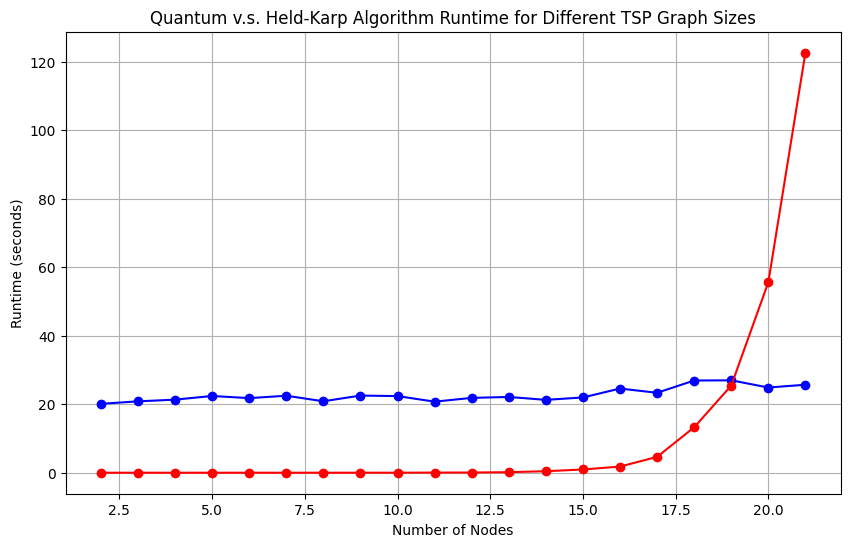

In [8]:
# testing
# Run the quantum TSP for different graph sizes
# Initialize the Qiskit Runtime Service and specify the backend
node_sizes = [2, 3, 4, 5, 6, 7 ,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

service = QiskitRuntimeService()
backend = service.backend('ibm_rensselaer')

# Run TSP and measure runtimes
runtimesC = run_tsp_on_graph_sizes(node_sizes)

runtimesQ = run_tsp_for_different_sizes_quantum(backend, node_sizes)

for i in range(len(node_sizes)):
    print(f"Nodes {node_sizes[i]}: Held-Karp Runtime was {(runtimesC[i]):.4f} seconds and Quantum Runtime was {runtimesQ[i]:.4f} seconds")

# Plot the runtimes
plt.figure(figsize=(10, 6))
plt.plot(node_sizes, runtimesQ, marker='o', linestyle='-', color='b', label='Quantum')
plt.plot(node_sizes, runtimesC, marker='o', color='r', label='Held-Karp')

plt.title('Quantum v.s. Held-Karp Algorithm Runtime for Different TSP Graph Sizes')
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (seconds)')

plt.legend()

plt.grid(True)
plt.show()
